# IN_GAME SPENDING HABIT ANALYSIS

A game designer has posed the challenge of identifing users that are likely to spend money in their game after finishing the tutorial. The goal is to identify
new users who are likely to spend money in the game and present them with different prices. This is a binary classification problem, where only the user and device data will be available for prediction at test time. As I suspect the data will be imbalanced, we will use the ROC/AUC to select a model and also look at the Gain-Chart and Uplift for a more holistic view of the solution

Here are my first observations:


1.   The total_spend data is presented as continuous value rather than binary.
2.   Looking at the dataset statics and noticed there is a large class imbalance with most users not spending any money. This will later require rebalancing as we train our algorithm.
3.   There are several entries with NUll/NaN value in one or more of their columns.
4.   'object'/'categorical' variables' statistic show that some have thousands of unique entries which would rapidly increase our feature space when one-hot-encoded.


Steps to address the above observations

1.   Total_spend data binarized using zero as a threshold
2.   Majority randomly downsampled and minority class randomly upsampled only for the training data
3.   Since the number of NaN and NULL is rare in the positive(minority) class, I dropped all rows that have any NULL entry in the user and action table.

4.   For columns with object data type, unique elements were ranked in descending order based on their frequency and only the top k+1 (user input parameter) unique values are retained, with one unique value containing all unique entries with frequency less than the kth unique value. The (at most k+1) categories are then on-hot-encoded. 


Once encoded a tree-based classifier is trained with 'gini' as the deciding factor for a split. The performance of the model is observed via construction of an ROC-curve and PR-curve. A lift-up/ Gain Chart is also constructed to evaluate how effective the new pricing campaign would be, if based on the developed model.

It is worth noting that, while we are given the actions data from past users, we can't use data as is to train our model, since it will not be available for a new user. Therefore our prediction accuracy will not be so great, if we decide to advertize the new prices after we have data on the user our model (trained on the action) data would be able to better predict the likelihood that a user will spend money in the game. The most important features for determining whether a user will spend money or not based solely on user and device data are:


*   local day of the week - (Sat, Sun, Mon - showing high correlation with purchase)
*   local time of join - (9AM - 11PM - showing high correlation with purchase)
*   main memory size - < (6000 - showing high correlation with purchase)
*   height of device - (500 - 1000 correlating well with purchase)

Therefore, if there is no action available for the user, a special price could be advertized to users whose activity or device falls in the above category.




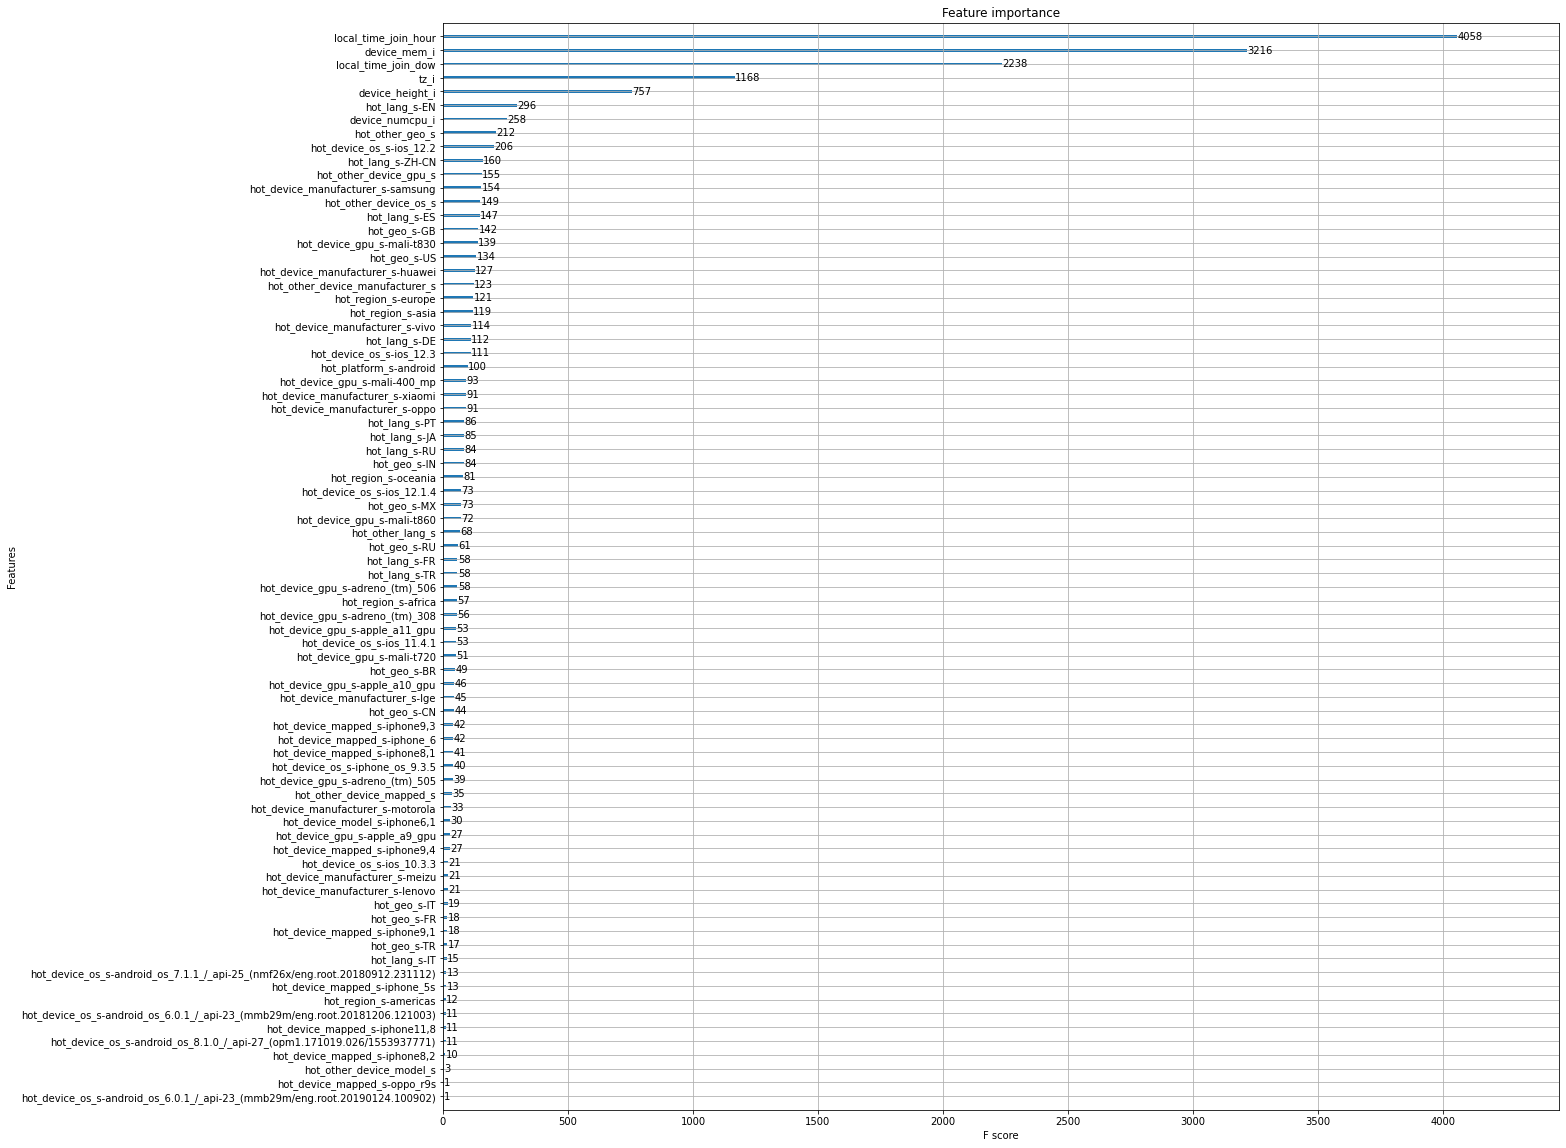

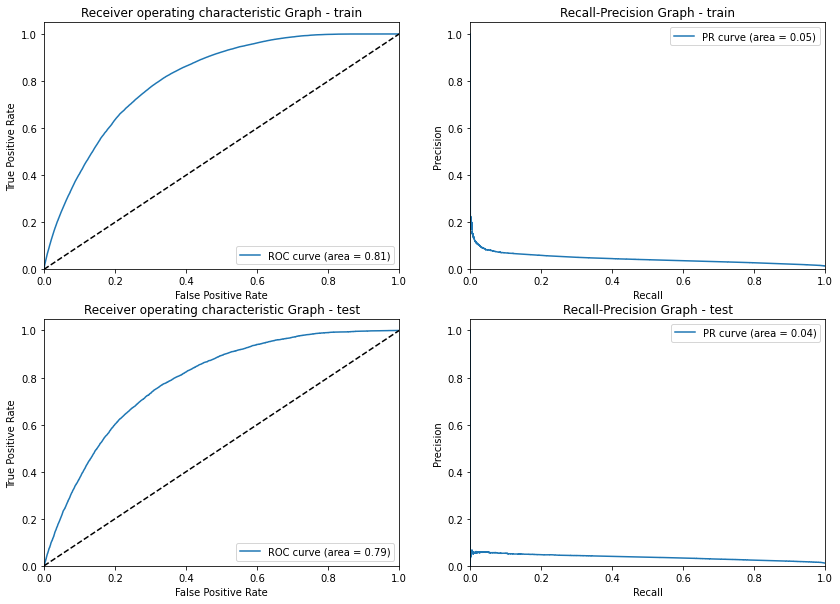

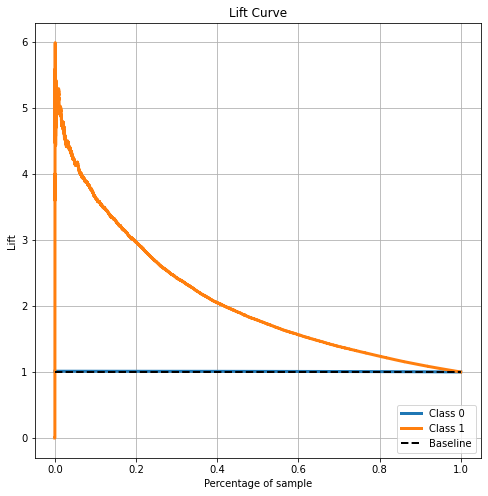

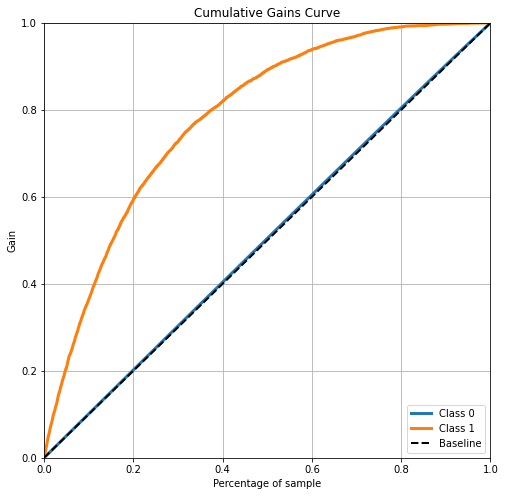

# Load Packages

In [1]:
# Set to false for local runtime
COLAB = False

In [2]:
import os
import sqlite3
from collections import defaultdict, Counter

import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler

try:
    import scikitplot
except:
    !pip install scikit-plot


from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.ensemble import RandomForestClassifier

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')

    os.chdir('/content/drive/MyDrive/kabam')

# Load data

In [ ]:
conn = sqlite3.connect('./kabam_ds_interview/ka_devices.db') 
          
sql_query = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM DEVICES
                               ''', conn)

devices = pd.DataFrame(sql_query, columns = ['uid_s', 'platform_s' , 'device_mapped_s' , 'device_manufacturer_s' , 
                                        'device_mem_i', 'device_gmem_i' , 'device_mem_grouping_i' , 
                                        'device_gmem_grouping_i' , 'device_numcpu_i' , 'device_height_i' , 
                                        'device_gpu_s', 'device_os_s', 'device_model_s'])
conn.close()
devices.head(3)

,uid_s,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
0,0,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,1,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,2,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6


In [ ]:
actions = pd.read_parquet("./kabam_ds_interview/ka_actions.parquet")

actions.head(3)

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
0,0,7.0,1.0,470000000.0,1693.0,592.0,0.0,429.0,446.0,364.0
1,1,2.0,1.0,612000000.0,197.0,197.0,0.0,0.0,60.0,125.0
2,2,2.0,1.0,390000000.0,313.0,313.0,0.0,0.0,89.0,129.0


In [ ]:
users = pd.read_csv("./kabam_ds_interview/ka_users.csv")

users.head(3)

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
0,0,EN,MY,asia,28800,14,3,0
1,1,ES,MX,americas,-18000,14,1,0
2,2,ZH-CN,CN,asia,28800,2,3,0


## Merge Tables

In [ ]:
user_device = users.set_index('uid_s').join(
    devices.set_index('uid_s'), on='uid_s', how='left')

In [ ]:
user_device_action = user_device.join(actions.set_index('uid_s'), on='uid_s', how='left')

user_device_action.head(3)

,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s,label,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
uid_s,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,EN,MY,asia,28800,14,3,0,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad,0,7.0,1.0,470000000.0,1693.0,592.0,0.0,429.0,446.0,364.0
1,ES,MX,americas,-18000,14,1,0,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5),0,2.0,1.0,612000000.0,197.0,197.0,0.0,0.0,60.0,125.0
2,ZH-CN,CN,asia,28800,2,3,0,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6,0,2.0,1.0,390000000.0,313.0,313.0,0.0,0.0,89.0,129.0


In [ ]:
user_device_action['label'] = (user_device_action.total_spend > 0)*1

user_device_action.describe()

,tz_i,local_time_join_hour,local_time_join_dow,total_spend,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,label,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
count,2.845931e+06,2.845931e+06,2.845931e+06,2.845931e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845931e+06,2.845894e+06,1.756997e+06,1.751748e+06,2.083043e+06,2.083043e+06,2.083043e+06,2.083043e+06,2.835649e+06,2.845930e+06
mean,1.113074e+04,1.474042e+01,4.207324e+00,1.215356e+00,2.668946e+03,8.180216e+02,2.701934e+03,8.180216e+02,5.814524e+00,8.908536e+02,1.138327e-02,2.961407e+00,9.970125e-01,1.750700e+09,8.966738e+02,4.481845e+02,1.290063e+02,7.907115e+01,1.312056e+02,1.332405e+02
std,1.926607e+04,5.673928e+00,2.305829e+00,1.386070e+01,2.870858e+03,5.216923e+02,2.871435e+03,5.216923e+02,2.426736e+00,2.548661e+02,1.060834e-01,2.254042e+00,5.457619e-02,3.818346e+09,7.353939e+03,6.952799e+03,5.728121e+02,5.018453e+02,2.295778e+02,9.406660e+01
min,-3.960000e+04,0.000000e+00,1.000000e+00,0.000000e+00,3.410000e+02,1.280000e+02,3.840000e+02,1.280000e+02,1.000000e+00,2.400000e+02,0.000000e+00,1.000000e+00,0.000000e+00,2.280000e+08,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
25%,-1.080000e+04,1.100000e+01,2.000000e+00,0.000000e+00,1.822000e+03,5.120000e+02,1.856000e+03,5.120000e+02,4.000000e+00,7.200000e+02,0.000000e+00,2.000000e+00,1.000000e+00,5.080000e+08,9.000000e+01,8.000000e+01,0.000000e+00,0.000000e+00,2.500000e+01,7.000000e+01
50%,1.980000e+04,1.600000e+01,4.000000e+00,0.000000e+00,2.753000e+03,1.024000e+03,2.816000e+03,1.024000e+03,8.000000e+00,8.000000e+02,0.000000e+00,2.000000e+00,1.000000e+00,6.370000e+08,3.130000e+02,3.090000e+02,0.000000e+00,0.000000e+00,5.300000e+01,1.290000e+02
75%,2.880000e+04,1.900000e+01,6.000000e+00,0.000000e+00,3.595000e+03,1.024000e+03,3.648000e+03,1.024000e+03,8.000000e+00,1.080000e+03,0.000000e+00,3.000000e+00,1.000000e+00,9.430000e+08,7.860000e+02,5.950000e+02,0.000000e+00,0.000000e+00,1.340000e+02,1.670000e+02
max,4.140000e+04,2.300000e+01,7.000000e+00,4.500000e+02,4.148139e+06,2.621440e+05,4.148160e+06,2.621440e+05,3.200000e+01,2.960000e+03,1.000000e+00,8.790000e+02,1.000000e+00,2.880000e+10,1.000023e+07,1.000023e+07,4.604800e+04,4.697300e+04,9.078000e+03,1.072000e+04


# Data Preprocessing

Counts
{0: 2813535, 1: 32396}
Ratio
86.84822200271638


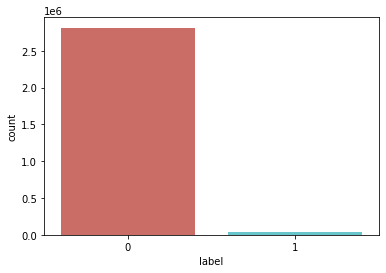

In [ ]:
print('Counts')
label_counts = user_device_action.groupby('label').size().to_dict()
print(label_counts)

print('Ratio')
print(label_counts[0]/label_counts[1])
countplt=sns.countplot(x='label', data=user_device_action, palette ='hls')

In [ ]:
null_values = user_device_action.groupby('label').apply(lambda x: x.isnull().sum())

null_values = null_values.loc[:, (null_values != 0).any(axis=0)]

null_values

,geo_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
label,,,,,,,,,,,,,,,,,,,,,
0,125,5,5,0,0,0,0,0,0,0,0,5,37,1087262,1092479,761809,761809,761809,761809,10273,1
1,1,1,1,1,1,1,1,1,1,1,1,1,0,1672,1704,1079,1079,1079,1079,9,0


In [ ]:
user_device_action_drop = user_device_action.dropna(axis=0, how='any',
                                                    subset=user_device.columns.tolist(), 
                                                    inplace=False)

null_values = user_device_action_drop.groupby('label').apply(lambda x: x.isnull().sum())

null_values = null_values.loc[:, (null_values != 0).any(axis=0)]

null_values

,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
label,,,,,,,,,
0,37,1087198,1092415,761764,761764,761764,761764,10271,1
1,0,1672,1704,1079,1079,1079,1079,9,0


In [ ]:
nan_cols = null_values.columns.tolist()

In [ ]:
user_device_action_imputed = user_device_action_drop.copy()

In [ ]:
user_device_action_imputed.loc[:,nan_cols] = user_device_action_imputed.loc[:,nan_cols].fillna(
    value=user_device_action_imputed.loc[:,nan_cols].mean(), 
    inplace=False)

In [ ]:
null_values = user_device_action_imputed.groupby('label').apply(lambda x: x.isnull().sum())
null_values.sum(axis=1)

label
0    0
1    0
dtype: int64

Counts
{0: 2813403, 1: 32395}
Ratio
86.8468282142306


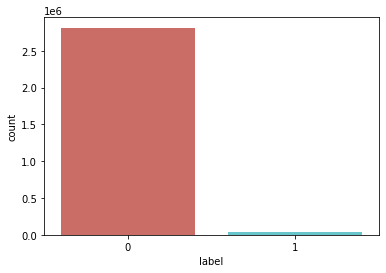

In [ ]:
print('Counts')
label_counts = user_device_action_imputed.groupby('label').size().to_dict()
print(label_counts)

print('Ratio')
print(label_counts[0]/label_counts[1])
countplt=sns.countplot(x='label', data=user_device_action_imputed, palette ='hls')

In [ ]:
final_df = user_device_action_imputed.drop('total_spend',axis=1)

final_df.head(3)

,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s,label,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
uid_s,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,EN,MY,asia,28800,14,3,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad,0,7.0,1.0,470000000.0,1693.0,592.0,0.0,429.0,446.0,364.0
1,ES,MX,americas,-18000,14,1,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5),0,2.0,1.0,612000000.0,197.0,197.0,0.0,0.0,60.0,125.0
2,ZH-CN,CN,asia,28800,2,3,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6,0,2.0,1.0,390000000.0,313.0,313.0,0.0,0.0,89.0,129.0


# Data Processing - object columns

In [ ]:
final_df_indexed = final_df.copy()

# Identify columns that need to be encoded
categ_cols = final_df.columns[final_df.dtypes=='object'].tolist()
categ_counts = final_df[categ_cols].apply(pd.Series.nunique).to_dict()

print('Columns to be one_hot_encoded')
print(categ_counts)


# Kepp the top {CATEG_LIM} of the unique values based on descreasing frequency
top_features = defaultdict(list)

CATEG_LIM = 10

## Identify the distinct features
for col in categ_cols:
    sorted_features = sorted(
        [(key,val) for key,val in final_df.groupby(col).size().to_dict().items()],
        key = lambda x: x[1], reverse=True)[:CATEG_LIM]
    
    top_features[col]=list(zip(*sorted_features))
    
## Add new column where features with frequency less than the top {CATEG_LIM} are set to 'other'
for col in categ_cols:
    feats = list(top_features[col][0])
    final_df_indexed[col+"_idx"] = 'other_'+col

    final_df_indexed.loc[final_df[col].isin(feats),col+"_idx"] = col +"-"+final_df_indexed[col]

    
categ_cols_indexed = [col+"_idx" for col in categ_cols]
unique_counts = final_df_indexed[categ_cols_indexed].apply(pd.Series.nunique)

print(f"Number of columns changed from {len(final_df.columns)} to {len(final_df_indexed.columns)}")

assert max(unique_counts.tolist()) <= CATEG_LIM + 1


hot_encoded = pd.get_dummies(final_df_indexed, prefix='hot', prefix_sep='_',
               columns=categ_cols_indexed, sparse=False, drop_first=False, dtype=None)


Columns to be one_hot_encoded
{'lang_s': 17, 'geo_s': 228, 'region_s': 6, 'platform_s': 2, 'device_mapped_s': 18970, 'device_manufacturer_s': 3025, 'device_gpu_s': 565, 'device_os_s': 75061, 'device_model_s': 19077}
Number of columns changed from 28 to 37


In [ ]:
hot_encoded.drop(categ_cols, axis=1, inplace=True)

hot_encoded.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

In [ ]:
assert max(Counter(hot_encoded.columns).values())==1, "There are duplicate columns in the dataframe"

print(f"Number of features after one-hot-encoding: {len(hot_encoded.columns)-1}")

Number of features after one-hot-encoding: 103


# Training and Testing split

Remove the features acquired after game play - actions

In [ ]:
print(len(hot_encoded.columns))
hot_encoded.drop(actions.drop('uid_s',axis=1).columns,axis=1, inplace=True)

print(len(hot_encoded.columns))

104
95


In [ ]:
label = hot_encoded.loc[:,'label']
features = hot_encoded.drop('label',axis=1)

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    label,
                                                    test_size=0.2, train_size=0.8, 
                                                    random_state=42, shuffle=True)

Train Data Counts
{0: 2250636, 1: 26002}

Train Data Ratio
86.5562649026998


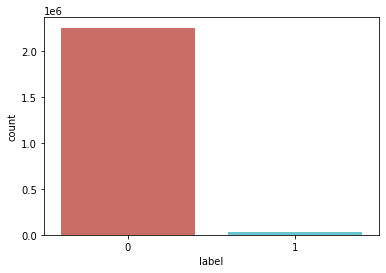

In [ ]:
train_data = X_train.copy()
train_data['label'] = y_train

print('Train Data Counts')
train_counts = train_data.groupby('label').size().to_dict()
print(train_counts)

print('\nTrain Data Ratio')
print(train_counts[0]/train_counts[1])

countplt=sns.countplot(x='label', data=train_data, palette ='hls')

Test Data Counts
{0: 562767, 1: 6393}

Test Data Ratio
88.02862505865791


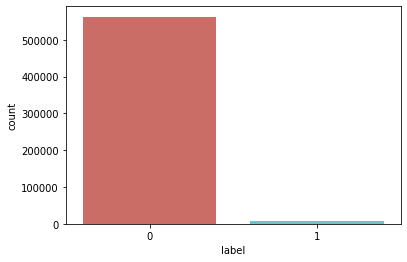

In [ ]:
test_data = X_test.copy()
test_data['label'] = y_test

print('Test Data Counts')
test_counts = test_data.groupby('label').size().to_dict()
print(test_counts)

print('\nTest Data Ratio')
print(test_counts[0]/test_counts[1])


countplt=sns.countplot(x='label', data=test_data, palette ='hls')

# Training data augmentation

In [ ]:
###### ---------- TODO
# Should probably look into stratified sampling
# resample using sklearn utils

## Undersample Majority Class

In [ ]:
undersample_model = RandomUnderSampler(sampling_strategy=1/10)

X_under, y_under = undersample_model.fit_resample(
    train_data.drop('label',axis=1), train_data.loc[:,'label'])

## Oversample Minority Class

In [ ]:
oversample_model = RandomOverSampler(random_state=42, sampling_strategy=1/4)

X_resampled, y_resampled = oversample_model.fit_resample(X_under, y_under)


Resampled Data Counts
{0: 260020, 1: 65005}

Resampled Data Ratio
4.0


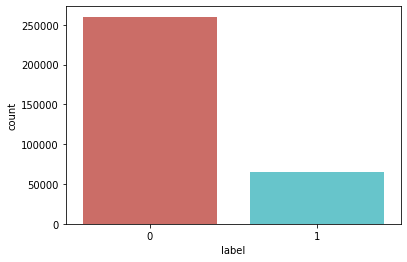

In [ ]:
# Combine into a single pandas dataframe
resampled_data = X_resampled.copy()
resampled_data['label'] = y_resampled

print('Resampled Data Counts')
resampled_counts = resampled_data.groupby('label').size().to_dict()
print(resampled_counts)

print('\nResampled Data Ratio')
print(resampled_counts[0]/resampled_counts[1])


countplt=sns.countplot(x='label', data=resampled_data, palette ='hls')

# Train Classifier

In [ ]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline, X_resampled, y_resampled, scoring='f1_micro', cv=cv, n_jobs=-1)
# score = np.mean(scores)
# print('F1 Score: %.3f' % score)

In [ ]:
clf = xgb.XGBClassifier(n_estimators=50,max_depth=10,learning_rate=0.1,use_label_encoder=False)


# clf = RandomForestClassifier(n_estimators=20, max_depth=10)
# clf = DecisionTreeClassifier(random_state=0, max_depth=10)
# clf = DummyClassifier(strategy='stratified')

fitted_model = clf.fit(X_resampled, y_resampled)

# Evaluate Metrics For Train (pre augmentation) and Test Datasets

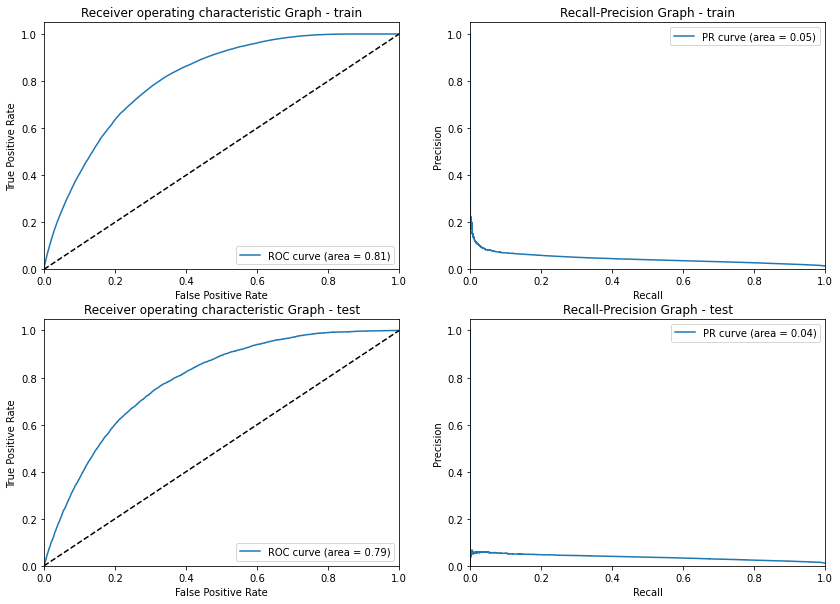

In [ ]:
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

data_set_type = ['train', 'test']

for i,data_set in enumerate([train_data, test_data]):
    
    preds = fitted_model.predict_proba(data_set.drop('label',axis=1))


    ## prepare score-label set
    results_collect = list(zip(preds, data_set['label'].tolist()))
    results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]


    fpr, tpr, _ = roc_curve(data_set['label'].tolist(), preds[:,1])
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(data_set['label'].tolist(), preds[:,1])
    pr_auc = auc(recall, precision)
    
    roc_ax, pr_ax = ax[i]
    
    roc_ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    roc_ax.plot([0, 1], [0, 1], 'k--')
    roc_ax.set_xlim([0.0, 1.0])
    roc_ax.set_ylim([0.0, 1.05])
    roc_ax.set_xlabel('False Positive Rate')
    roc_ax.set_ylabel('True Positive Rate')
    roc_ax.set_title(f'Receiver operating characteristic Graph - {data_set_type[i]}')
    roc_ax.legend(loc="lower right")

    pr_ax.plot(recall, precision, label='PR curve (area = %0.2f)' % pr_auc)
    # pr_ax.plot([0, 1], [0, 1], 'k--')
    pr_ax.set_xlim([0.0, 1.0])
    pr_ax.set_ylim([0.0, 1.05])
    pr_ax.set_xlabel('Recall')
    pr_ax.set_ylabel('Precision')
    pr_ax.set_title(f'Recall-Precision Graph - {data_set_type[i]}')
    pr_ax.legend(loc="upper right")


plt.show()

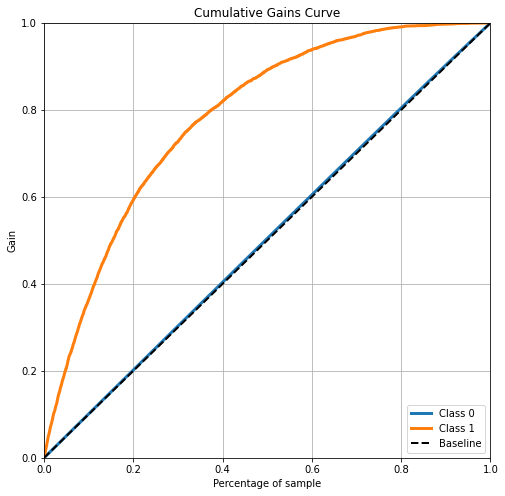

In [ ]:
ax = plt.figure(figsize=(8,8)).gca()
plot_cumulative_gain(test_data['label'].tolist(), preds, ax=ax)
plt.show()

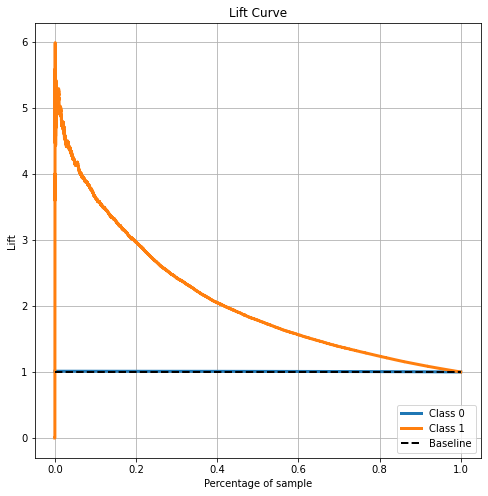

In [ ]:
ax = plt.figure(figsize=(8,8)).gca()
plot_lift_curve(test_data['label'].tolist(), preds, ax=ax)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.274465 to fit


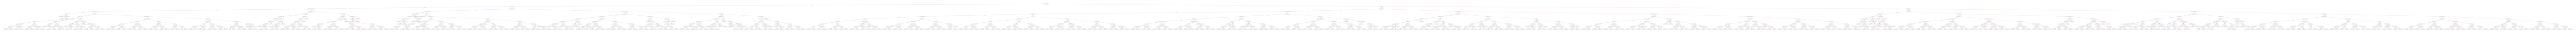

In [ ]:
ax = plt.figure(figsize=(100,100)).gca()
xgb.plot_tree(fitted_model,num_trees=0,ax=ax)
plt.savefig('tree.png', padinches=0, bbox_inches='tight')
plt.show()

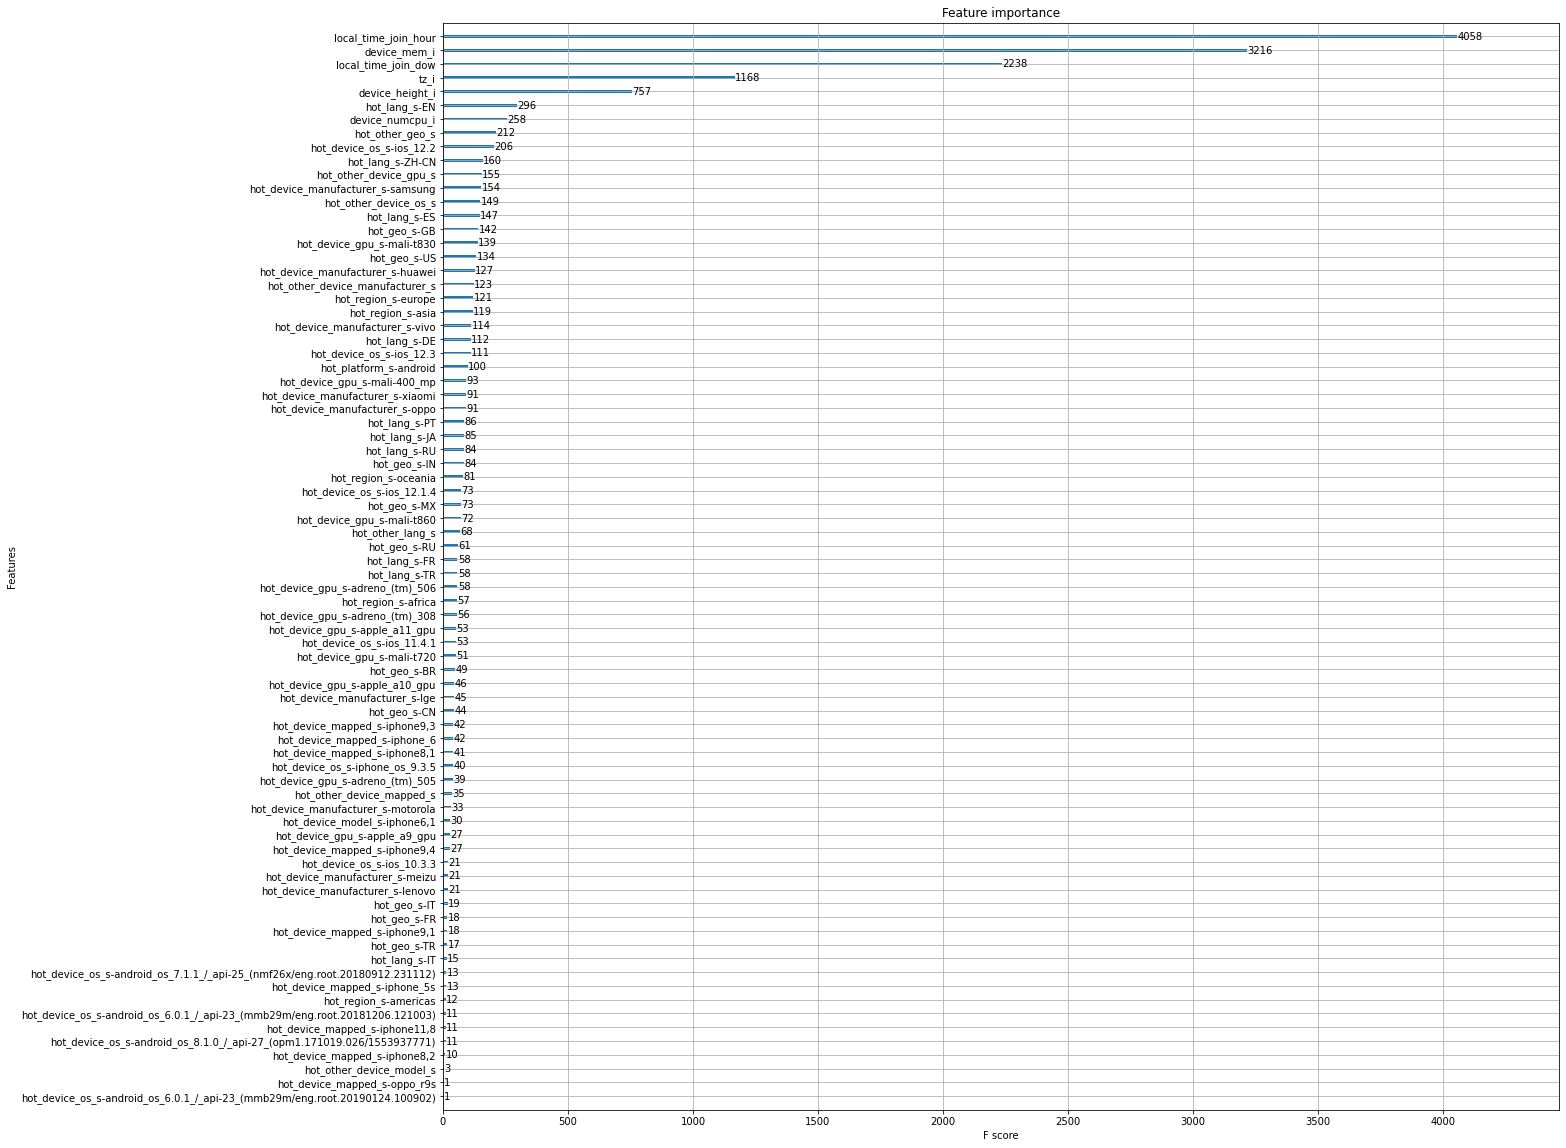

In [ ]:
ax = plt.figure(figsize=(20,20)).gca()
xgb.plot_importance(fitted_model, ax=ax)
plt.show()

In [ ]:
print(train_data.groupby('local_time_join_dow')['label'].sum())

print(test_data.groupby('local_time_join_dow')['label'].sum())


local_time_join_dow
1    5200
2    2965
3    2604
4    2289
5    2039
6    4352
7    6553
Name: label, dtype: int64
local_time_join_dow
1    1295
2     764
3     662
4     549
5     507
6    1024
7    1592
Name: label, dtype: int64


In [ ]:
print(train_data.groupby('local_time_join_hour')['label'].sum())

print(test_data.groupby('local_time_join_hour')['label'].sum())

local_time_join_hour
0      854
1      562
2      346
3      212
4      188
5      170
6      440
7      693
8      935
9     1089
10    1237
11    1275
12    1455
13    1317
14    1283
15    1387
16    1419
17    1568
18    1554
19    1707
20    1698
21    1789
22    1623
23    1201
Name: label, dtype: int64
local_time_join_hour
0     207
1     124
2     124
3      60
4      44
5      36
6      88
7     176
8     228
9     283
10    272
11    327
12    342
13    334
14    306
15    352
16    357
17    364
18    430
19    378
20    428
21    453
22    374
23    306
Name: label, dtype: int64


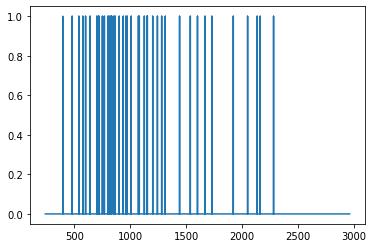

In [ ]:
height_label = sorted(list(zip(train_data['device_height_i'],train_data['label'])),key=lambda x: x[0])

height = [x[0] for x in height_label]
purchase = [x[1] for x in height_label]

plt.plot(height, purchase)
plt.show()

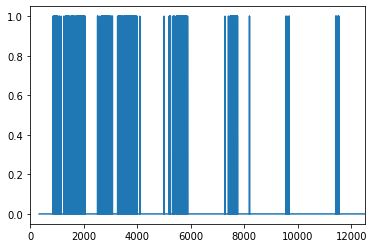

In [ ]:

mem_label = sorted(list(zip(train_data['device_mem_i'],train_data['label'])),key=lambda x: x[0])

mem = [x[0] for x in mem_label]
purchase = [x[1] for x in mem_label]

plt.plot(mem, purchase)
plt.xlim([0,1.25e4])
plt.show()